In [1]:
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
import time
import torch.nn as nn
from torchdiffeq import odeint_adjoint as odeint

cuda = True

In [2]:
train = np.load("./data/loc_train_springs5.npy")

print(train.shape)
print(train[0][:][0][1].shape)

(100, 49, 2, 5)
(5,)


(5, 2, 49)


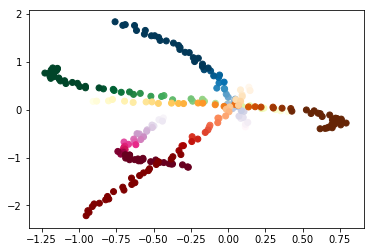

In [3]:
data = train[10]
data = np.transpose(data)
print(data.shape)
maps = [cm.PuRd, cm.YlGn, cm.PuBu, cm.YlOrBr, cm.OrRd]
for part in range(5):
    cmap = maps[part](10*np.arange(49))
    plt.scatter(*data[part], c=cmap)

In [4]:
from utils import *
from modules import *

SUFFIX = "_springs5"

train_loader, valid_loader, test_loader, loc_max, loc_min, vel_max, vel_min = load_data(
    64, SUFFIX)



In [20]:
def mse_loss(input, target):
    return torch.sum((input - target)**2) / input.data.nelement()

def train(epoch, best_val_loss):
    t = time.time()
    nll_train = []
    acc_train = []
    kl_train = []
    mse_train = []

    model.encoder.train()
    model.decoder.train()
    scheduler.step()
    for batch_idx, (data, relations) in enumerate(train_loader):

        if cuda:
            data, relations = data.cuda(), relations.cuda()
        data, relations = Variable(data), Variable(relations)
        optimizer.zero_grad()

        odeparams = model.encoder(data)
        
        T = torch.linspace(1, NUM_TIMESTEPS, NUM_TIMESTEPS - 1).cuda()
        output = model.decoder(odeparams, data, T)

        target = data[:, :, 1:, :]

        loss = mse_loss(output.view(-1, 5, 48, 4), target)

        loss.backward()
        optimizer.step()

        mse_train.append(loss.item())

    mse_val = []

    model.encoder.eval()
    model.decoder.eval()
    for batch_idx, (data, relations) in enumerate(valid_loader):
        if cuda:
            data, relations = data.cuda(), relations.cuda()
        data, relations = Variable(data, volatile=True), Variable(
            relations, volatile=True)

        odeparams = model.encoder(data)
        
        T = torch.linspace(1, NUM_TIMESTEPS, NUM_TIMESTEPS - 1).cuda()
        output = model.decoder(odeparams, data, T)

        target = data[:, :, 1:, :]

        loss = mse_loss(output.view(-1, 5, 48, 4), target)

        loss.backward()
        optimizer.step()

        mse_val.append(loss.item())

    print('Epoch: {:04d}'.format(epoch),
          'mse_train: {:.10f}'.format(np.mean(mse_train)),
          'mse_val: {:.10f}'.format(np.mean(mse_val)),
          'time: {:.4f}s'.format(time.time() - t))
    
    return np.mean(mse_val)

In [6]:
NUM_EPOCHS = 100
NUM_TIMESTEPS = 49 
PREDICTION_STEPS = 50
NUM_ODE_PARAMS = 10

NUM_ATOMS = 5
EDGE_TYPES = 2


DECODER_HIDDEN = 256
SKIP_FIRST = False
DECODER_DROPOUT = 0.0

In [22]:
class ODEFunc(nn.Module):
    def __init__(self, net, odeparams):
        super().__init__()
        self.odeparams = odeparams
        self.net = net
        
    
    def forward(self, t, y):
        return self.net(torch.cat((y, self.odeparams), -1))
        
    
class ODEEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(49*5*4, 1024),
                                 nn.Tanh(),
                                 nn.Linear(1024, 1024),
                                 nn.Tanh(),
                                 nn.Linear(1024, NUM_ODE_PARAMS))
        
    def forward(self, data):
        data = data.view(data.shape[0], -1)
        return self.net(data)
    
class ODEDecoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(2*2*5 + NUM_ODE_PARAMS, 50),
                                 nn.Tanh(),
                                 nn.Linear(50, 2*2*5))
        
    def forward(self, odeparams, data, t):
        data = data[:, :, t.long() - 1, :].contiguous().view(data.shape[0], -1)
        return odeint(ODEFunc(self.net, odeparams), data, torch.ones(1))
    
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = ODEEncoder()
        self.decoder = ODEDecoder()
        
    def forward(self, a):
        pass

    
model = Model().cuda()
model

Model(
  (encoder): ODEEncoder(
    (net): Sequential(
      (0): Linear(in_features=980, out_features=1024, bias=True)
      (1): Tanh()
      (2): Linear(in_features=1024, out_features=1024, bias=True)
      (3): Tanh()
      (4): Linear(in_features=1024, out_features=10, bias=True)
    )
  )
  (decoder): ODEDecoder(
    (net): Sequential(
      (0): Linear(in_features=30, out_features=50, bias=True)
      (1): Tanh()
      (2): Linear(in_features=50, out_features=20, bias=True)
    )
  )
)

In [8]:
import torch.optim as optim
from torch.optim import lr_scheduler

optimizer = optim.Adam(list(model.encoder.parameters()) + list(model.decoder.parameters()),lr=1e-4)
scheduler = lr_scheduler.StepLR(optimizer, step_size=200,gamma=0.5)

In [23]:
t_total = time.time()
best_val_loss = np.inf
best_epoch = 0
for epoch in range(NUM_EPOCHS):
    val_loss = train(epoch, best_val_loss)
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch
print("Optimization Finished!")
print("Best Epoch: {:04d}".format(best_epoch))



RuntimeError: size mismatch, m1: [64 x 970], m2: [30 x 50] at /opt/conda/conda-bld/pytorch_1533672544752/work/aten/src/THC/generic/THCTensorMathBlas.cu:249

In [ ]:
### Prediction of model with right position at each step


f, axarr = plt.subplots(5, 2, figsize=(15, 30))
batch = next(iter(test_loader))[0][0:5]

model.encoder.eval()
model.decoder.eval()

x = batch.narrow(2,0,49).cuda()
odeparams = model.encoder(x)

T = torch.linspace(0, NUM_TIMESTEPS, NUM_TIMESTEPS).cuda()
T = torch.ones(1)
prediction = model.decoder(odeparams, x, T)#.view(5, 49, 5, 4)
print(prediction.shape)


maps = [cm.PuRd, cm.YlGn, cm.PuBu, cm.YlOrBr, cm.OrRd]

# maps = ['g', 'b', 'k', 'r', 'c']

for i, ax in enumerate(axarr.flat):
    b = torch.transpose(x[i//2], 1,2)
#     print(b.shape)
    if i%2==0:
        for j in range(5):
            cmap = maps[j](10*np.arange(49))
            ax.scatter(b[j][0], b[j][1], c=cmap)
            
#             cmap = maps[j]
#             ax.scatter(b[j][0], b[j][1], c=cmap, alpha=1)
            

    else:
        
        b = torch.transpose(prediction[i//2], 1,2).cpu().detach().numpy()
#         print(b.shape)
        for j in range(5):
            cmap = maps[j](10*np.arange(48))
            ax.scatter(b[j][0], b[j][1], c=cmap)            
#                 cmap = maps[j]
#                 ax.scatter(b[j][0], b[j][1], c=cmap, alpha = 0.05)



    

In [ ]:
f, axarr = plt.subplots(5, 2, figsize=(15, 30))
batch = next(iter(test_loader))[0][10:15]

model.encoder.eval()
model.decoder.eval()

pred_steps = 50 
BURN_IN = False
BURN_IN_STEPS = 30
DYNAMIC_GRAPH = False


x = batch.narrow(2,0,49).cuda()
odeparams = model.encoder(x)

T = torch.linspace(0, NUM_TIMESTEPS, NUM_TIMESTEPS).cuda()
output = model.decoder(odeparams, x, T)

output = output.view(5, 49, 5, 4).transpose(1,2)


# maps = [cm.PuRd, cm.YlGn, cm.PuBu, cm.YlOrBr, cm.OrRd]

maps = ['g', 'b', 'k', 'r', 'c']


for i, ax in enumerate(axarr.flat):
    b = torch.transpose(batch[i//2], 1,2)
#     print(b.shape)
    if i%2==0:
        for j in range(5):
#             cmap = maps[j](10*np.arange(49))
#             ax.scatter(b[j][0], b[j][1], c=cmap)
            
            cmap = maps[j]
            ax.scatter(b[j][0][:49], b[j][1][:49], c=cmap, alpha = 0.2)
            ax.scatter(b[j][0][49:], b[j][1][49:], c=cmap, alpha = 1)
            

    else:
        
        b = torch.transpose(batch[i//2], 1,2).cpu().detach().numpy()
        d = torch.transpose(output[i//2], 1,2).cpu().detach().numpy()

        for j in range(5):
#             cmap = maps[j](10*np.arange(48))
#             ax.scatter(b[j][0], b[j][1], c=cmap)  

            cmap = maps[j]
            ax.scatter(b[j][0][:49], b[j][1][:49], c=cmap, alpha = 0.2)
            ax.scatter(d[j][0], d[j][1], c=cmap, alpha = 1)



    

In [ ]:
f, axarr = plt.subplots(5, 2, figsize=(15, 30))
batch = next(iter(test_loader))[0][40:45]

model.encoder.eval()
model.decoder.eval()

pred_steps = 50 

n_samples = 50

x = batch.narrow(2,0,49).cuda()
logits = model.encoder(x, rel_rec, rel_send)

inputs = batch.transpose(1, 2)
outputs_list = []
for sample in range(n_samples):
    edges = gumbel_softmax(logits, tau=TAU, hard=HARD)
    sizes = [edges.size(0), inputs.size(1), edges.size(1),
                 edges.size(2)]
    rel_type = edges.unsqueeze(1).expand(sizes)



    last_pred = inputs[:, 49::pred_steps, :, :].cuda()
    curr_rel_type = rel_type[:, 49::pred_steps, :, :].cuda()
    # NOTE: Assumes rel_type is constant (i.e. same across all time steps).


    # Run n prediction steps
    preds = []
    for step in range(0, pred_steps):
        last_pred = model.decoder.single_step_forward(last_pred, rel_rec, rel_send, curr_rel_type)
        preds.append(last_pred)

    sizes = [preds[0].size(0), preds[0].size(1) * pred_steps, preds[0].size(2), preds[0].size(3)]

    output = Variable(torch.zeros(sizes))
    if inputs.is_cuda:
        output = output.cuda()

    for i in range(len(preds)):
        output[:, i::pred_steps, :, :] = preds[i]

    output = output.transpose(1,2)
    outputs_list.append(output.cpu().detach())

# maps = [cm.PuRd, cm.YlGn, cm.PuBu, cm.YlOrBr, cm.OrRd]

maps = ['g', 'b', 'k', 'r', 'c']

xlim = []
ylim = []
for i, ax in enumerate(axarr.flat):
    b = torch.transpose(batch[i//2], 1,2)

#     print(b.shape)
    if i%2==0:
        for j in range(5):
            cmap = maps[j]
            ax.scatter(b[j][0][:49], b[j][1][:49], c=cmap, alpha = 0.2)
            ax.scatter(b[j][0][49:], b[j][1][49:], c=cmap, alpha = 1)
            xlim = ax.get_xlim()
            ylim = ax.get_ylim()


    else:

        b = torch.transpose(batch[i//2], 1,2).cpu().detach().numpy()
        for j in range(5):
            cmap = maps[j]
            #ax.scatter(b[j][0][:49], b[j][1][:49], c=cmap, alpha = 0.2)
        for output in outputs_list:
            d = torch.transpose(output[i//2], 1,2).numpy()
            for j in range(5):
                cmap = maps[j]
                ax.scatter(d[j][0], d[j][1], c=cmap, alpha = 0.1)
                ax.set_xlim(xlim)
                ax.set_ylim(ylim)



    